In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#import packages
import glob
import os
import numpy as np
import pickle
import platform
import math
from IPython.display import clear_output, display, HTML
from matplotlib.patches import Rectangle
from matplotlib import collections  as mc
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter as smooth
#import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### you might need to change the line below if you want to regenerate the figure on a differente computer 
### Below we will run some preprocessing notebooks. In our case, our preprocessing notebooks are located in 
### a folder ("load_preprocess_mouse") which is at the same level that the folder that contain the notebooks 
### that generate the figures (for instance this one)


notebookPath=os.path.dirname(os.path.realpath("__file__"))
pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_mouse")
os.chdir(pathToProcessingNotebooks)   
%run loadMouse_documentation.ipynb


#######

def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False

def cm2inch(value):
    return value/2.54
    

#Those parameters are overwritten if there is a .behav_param file
paramCarola={
    "distanceToRun":100,
    "maxTrialDuration": 60,
    "valveONTime":50,
    "minInterTrialDuration":15,
    "immobilityDuration":2,
    #to read .eeg (put None to not read .eeg)
    "nChannelElectro":32, #32
    "channel_opto": -6, #not used
    "channel_lickBreak":-5,
    "channel_reward": -4, #not used currently
    "channel_sound": -3, #not used
    "channel_trialON": -2,
    "channel_beamBreak": -1,
}    


#### root is the path to the folder where the data (MOUXXX, MOUXXY, ....ALLMOU_Analysis) are located
### you might need to change the line below depending on your computer orgnization

if platform.system()=='Linux':
    root="/data"
else:
    root="/Users/davidrobbe/Documents/Data/"
    
    
# Where to Save Files

pathToSaveFig=os.path.join(root,"ALLMOU_Analysis","FigForMS")
    
print("path to data is %s"%root)
print("")
print("importing done")

path to data is /data

importing done


In [2]:
def plot_SessionPerfoTryByTrialForFig(data,legend=False,colorOpto="orange",xmax=60,ax=None,lick=True,yLim=None,showYLabel=True):  
    if ax is None:
        ax = plt.gca()
    minTime= - max(data.durationTrial)
    maxTime= max(data.durationInterTrial)
    maxTime=min(xmax,maxTime)
    distanceToRun=data.distanceToRun[0]
    wheelLines=[]
    lickLines=[]
    rewardLines=[]

    #ticks where the distance to run has changed
    boldTicks={1:distanceToRun}
    
    for trial in data.trials:
        y1=trial+1.1
        y2=trial+1.1
        y3=trial+1.6
        y4=trial+1.9
        
        #we want to align the plot on the trial end (=reward =start of intertrial)
        zero=data.durationTrial[trial]
        
        if zero < 60:
            rewardLines.append([(0,trial+1.1),(0,trial+1.6)]) 
        
        #trial beam break time are relative to trial start
        for breakTime in data.beamBreakTime[trial]:
            x=breakTime-zero
            wheelLines.append([(x,y1),(x,y4)])
            
        #intertrial beam break time are already aligned correctly
        for x in data.beamBreakTime[trial+0.5]:
            wheelLines.append([(x,y1),(x,y4)])
            
        #if there is lick break times
        if (len(data.lickBreakTime)>0) and lick:
            for lickTime in data.lickBreakTime[trial]:
                x=lickTime-zero
                lickLines.append([(x,y2),(x,y3)])
            for x in data.lickBreakTime[trial+0.5]:
                lickLines.append([(x,y2),(x,y3)])
            
        #color in grey the duration of trial and intertrial
        endInterTrial=data.durationInterTrial[trial]
        ax.add_patch(Rectangle((-zero,trial+1), zero, 1, facecolor="lightgrey",edgecolor="none",zorder=-3))
        ax.add_patch(Rectangle((0,trial+1), endInterTrial, 1, facecolor="lavender",edgecolor="none",zorder=-3))
        #green square when 2 s immobility OK
        ax.add_patch(Rectangle((endInterTrial-2,trial+1.1), 2, 0.8, facecolor="none",edgecolor="limegreen",lw=0.5))
        #red square when 2 s immobility KO
        if data.durationInterTrial[trial]>data.minInterTrialDuration[trial]:
            ax.add_patch(Rectangle((data.minInterTrialDuration[trial]-2,trial+1.1), 2, 0.8, facecolor="none",edgecolor="red",lw=0.5))
                
    
        #Plot all the lines trial by trial
    lc = mc.LineCollection(wheelLines,colors="black",linewidths=0.5,zorder=-2)
    lc2= mc.LineCollection(lickLines,colors="blue",linewidths=0.5,zorder=-1)
    lc3= mc.LineCollection(rewardLines,colors="aqua",linewidths=2,zorder=-1)
    ax.add_collection(lc)
    ax.add_collection(lc2)
    ax.add_collection(lc3)


    
    #bold ticks
    space=10
    rangeList=list(set(range(10,data.nTrial+2,space)).union(boldTicks))
    ticksPosition=[y+0.5 for y in rangeList]
    #ticksLabel=[str(boldTicks[y])+"cm| "+str(y) if y in boldTicks else str(y) for y in rangeList]
    ticksLabel=[str(y) if y in boldTicks else str(y) for y in rangeList] 
    plt.yticks(ticksPosition,ticksLabel)
    ax.tick_params(axis='both',which='major',labelsize=10,direction='out')
    
    
    #axis limits
    ax.set_xlim([-xmax,40])
    ax.invert_yaxis()
    if yLim is None:
        ax.set_ylim([data.realTrials[-1]+1,data.realTrials[0]])
    else:
        ax.set_ylim([yLim,data.realTrials[0]])
    
   
    if showYLabel:
        ax.set_ylabel("First %s trials" %yLim,fontsize=12)     
    else:
        ax.yaxis.set_ticklabels([])
    
    ax.xaxis.set_ticklabels([])

    
    title=data.experiment+" (day "+str(data.daySinceStart)+")\nBeam and lick break time"
    if data.hasOptogenetic:
        title+="\n %s"%data.stimulationNames
    #plt.title(title,fontsize=14)
    
    #legend with no duplicate
    
#     if legend:
#         ax.plot([], [], linewidth=6,color='lightgrey', label="trial time range")
#         ax.plot([], [], linewidth=6,color='lavender', label="intertrial time range")
#         ax.legend(loc='best', bbox_to_anchor=(1, 1))
        
        
    ## new type of legends because no more figure 1 with detailed task explanation
    if legend:
        #ax.add_patch(Rectangle((1,1),1,1,color='lightgrey',label='run period'))
        #ax.add_patch([], [],[] ,color='lightgrey', label="run period")
        ax.plot([], [], linewidth=4,color='lightgrey', label="run period")
        ax.plot([], [], linewidth=4,color='lavender', label="no run period")
        ax.plot([], [],'|',color='black',ms=10,mew=1, label='wheel movement')
        ax.plot([], [],'|',color='blue',ms=6,mew=1, label='lick detection')
        ax.scatter([], [],marker='s',color='white',edgecolors='limegreen', label="2 s immobility OK",s=80)
        ax.scatter([], [],marker='s',color='white',edgecolors='red', label="2 s immobility KO",s=80)
        ax.plot([], [],'|',color='aqua',ms=6,mew=3, label='reward')
        #lg=ax.legend(loc='best', bbox_to_anchor=(1, 1))
        #lg=ax.legend(loc=(0.98,0),scatterpoints=1,numpoints=1)
        lg=ax.legend(loc=(-0.2,1.15),scatterpoints=1,numpoints=1,ncol=4,borderpad=0.2,labelspacing=0.25,handletextpad=0.5,columnspacing=0.5,handlelength=0.5)
        lg.get_frame().set_linewidth(0.0)
        for text,fontcolor in zip(lg.get_texts(),['lightgrey','lavender','black','blue','aqua','limegreen','red']):
            text.set_color(fontcolor)
        
        
    return title

    handles, labels = ax.get_legend_handles_labels()
    #lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))
    plt.tight_layout()
              


In [3]:
def plot_MeanPerfo(data,binSize=0.25,minTime=-60,maxTime=40,align="trial end",separate="good trial",
                     lick=False,s=1,onlySeparate=False,showYLabel=True):  
    '''
    s= sigma for smoothing mean running spead
    lick: True to plot lick frequency instead of runnign speed
    separate= "good trials" or "optogenetic" or "none"
    align= "trial end" or "trial start" (overriden by "stimulation start" in case of optogenetic after N ticks)
    onlySeparate: plot only the separated group, in black
    '''
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    #bins between minTime and maxTime
    timeBin=np.arange(minTime,maxTime+binSize-maxTime%binSize,binSize)
    centers=(timeBin[:-1]+timeBin[1:])/2.0    
    #lick or the beam breaks
    if lick:
        allBreak=np.asarray(data.allLickBreak)
    else:
        allBreak=np.asarray(data.allBeamBreak)
        
    
    color="black"
    linestyle="-"
    if separate=="good trial":
        color="black"
        linestyle="-"
        if lick:
            color="blue"
    
    if onlySeparate:
        color="black"
        linestyle="-"
        if lick:
            color="blue"
    
            
    
    separateBeamCount=[] #"good trials" 
    allBeamCount=[]      # all the other trials
    for trial in data.trials:
        if align=="trial end":
            zero=data.realStartTrial[trial]+data.durationTrial[trial]
        elif align=="trial start":
            zero=data.realStartTrial[trial]
               
        alignedBreak=allBreak-zero
        hist,bins=np.histogram(alignedBreak,timeBin)
        
        if (separate=="good trial") and (trial in data.goodTrials):
            separateBeamCount.append(hist) 
            continue
        elif (separate=="optogenetic") and (data.hasOptogenetic):
            if data.stimulationHappened[trial]==True:
                separateBeamCount.append(hist)
                continue
        if not onlySeparate:
            allBeamCount.append(hist)   
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        meanBeamCount=np.nanmean(np.asarray(allBeamCount),axis=0)
        meanSeparate=np.nanmean(np.asarray(separateBeamCount),axis=0)
      
    
   
    if lick:
        meanBin=meanBeamCount/float(binSize)
        meanBinSeparate=meanSeparate/float(binSize)
        if showYLabel:
            ax.set_ylabel("Mean lick\nrate (Hz)",fontsize=12)
            yticks = ax.yaxis.get_major_ticks()
            yticks[-1].label1.set_visible(False)
        else:
            ax.yaxis.set_ticklabels([])
            xticks = ax.xaxis.get_major_ticks()
            xticks[0].label1.set_visible(False)
        ax.set_ylim(0,10)
    else:
        meanBin=meanBeamCount*data.tickDistance/float(binSize)
        meanBinSeparate=meanSeparate*data.tickDistance/float(binSize)
        if showYLabel:
            ax.set_ylabel("Mean run\nspeed (cm/s)",fontsize=12)
            yticks = ax.yaxis.get_major_ticks()
            yticks[-1].label1.set_visible(False) 
        else:
            ax.yaxis.set_ticklabels([])
        ax.set_ylim(0,20)
            
               
    

    if len(separateBeamCount)>0:
        ax.plot(centers,smooth(meanBinSeparate,s),color=color,label=separate,linewidth=2,linestyle=linestyle)
        
        #plot if not empty (allbeamcount are the others)
    if len(allBeamCount)>0:
        if separate=="good trial" :
            linestyle=':'
        ax.plot(centers,smooth(meanBin,s),color=color,linewidth=2,linestyle=linestyle)

    #plt.xlabel("Time (s),  0=%s"%(align),fontsize=30,weight="bold")
    ax.set_xlim(minTime,maxTime)
    
    if lick: 
        if index==1:
            ax.set_xlabel("Time (s), relative to RP end",fontsize=12)
    else:
        ax.xaxis.set_ticklabels([])

        
    ax.axvspan(0, paramCarola["minInterTrialDuration"], facecolor="lavender",edgecolor="none")


    

## Population analysis on wheel task. all mice/sessions recorded by Carola are considered) 

### 1. Loops accross animals and session. Load performance value for each session (in learningStats.p). 
### 2 Concatenate all the values per parameteres. 
### 3. Get 20-50-80 percentile



In [4]:
behavioralParamsOfInterest=["Good trials Per 5 Min (trials/5min)","Median Trial Duration (s)","RunAndStopIndex"]
fileWithListAnimalsWithLearningCurve=os.path.join(root,"ALLMOU_Analysis","ListMOUIDLearningCurve.txt")
f=open(fileWithListAnimalsWithLearningCurve,"r")
animalList=[]
for line in f.readlines():
    animalList.append(line[:-1])

f.close()    

allSessionNamesAcrossAnimals=[]
allDataAccrossAnimals={}
numbersOfSessionsAcrossAnimals=[]
for key in behavioralParamsOfInterest:
    allDataAccrossAnimals[key]=[]

for animal in animalList:
#     print(animal,startstop)
            
    path=os.path.join(root,animal,"Analysis")
    pathPickle=os.path.join(path,"learningStats.p")
    with open(pathPickle,"rb") as f:
        results=pickle.load(f)

    allSessionNamesAcrossAnimals.extend(results["session"])
    numbersOfSessionsAcrossAnimals.extend([len(results['days'])])
    
    for key in behavioralParamsOfInterest:
        allDataAccrossAnimals[key].extend(results[key])


percentilesOfInterest=np.arange(20,100,30)
allPercentilesValues={}
for key in behavioralParamsOfInterest:
    # remove a few nan values
    originalDataWithNan=allDataAccrossAnimals[key]
    cleanedDataWithoutNan= [x for x in originalDataWithNan if not math.isnan(x)]
    #allDataAccrossAnimalsNoNan[key]=cleanedDataWithoutNan    
    allPercentilesValues[key]=np.percentile(cleanedDataWithoutNan,percentilesOfInterest)

        
       

        


In [5]:
animalList

['MOU001',
 'MOU002',
 'MOU004',
 'MOU006',
 'MOU007',
 'MOU013',
 'MOU015',
 'MOU016',
 'MOU017',
 'MOU018',
 'MOU019',
 'MOU024',
 'MOU025',
 'MOU026',
 'MOU027',
 'MOU028',
 'MOU029',
 'MOU030',
 'MOU031',
 'MOU032',
 'MOU033',
 'MOU074',
 'MOU075',
 'MOU079',
 'MOU093',
 'MOU094',
 'MOU100',
 'MOU101']

In [5]:
np.median(numbersOfSessionsAcrossAnimals)
np.sum(numbersOfSessionsAcrossAnimals)

2060

## Generate an empty (zeros) matrix of dimension:  nber of animal x max number of session  x nber of behav param.
###  For each param,animal,percentile, find the 1st session above percentile. all the sessions after are marked with a one.

In [6]:
# initialize matrix
thresholdMatrix=np.zeros((len(numbersOfSessionsAcrossAnimals),max(numbersOfSessionsAcrossAnimals),len(percentilesOfInterest),len(behavioralParamsOfInterest)))


animalindex=0

for animal in animalList:
    path=os.path.join(root,animal,"Analysis")
    pathPickle=os.path.join(path,"learningStats.p")
    with open(pathPickle,"rb") as f:
        results=pickle.load(f)
      
    for paramindex,parameter in enumerate(behavioralParamsOfInterest):
                  

        for valueIndex,valueToTest in enumerate(allPercentilesValues[parameter]):         

            if parameter=="Median Trial Duration (s)":
                Index=np.where(np.asarray(results[parameter])<valueToTest)[0]
            else:
                Index=np.where(np.asarray(results[parameter])>valueToTest)[0]

            if len(Index)>0:
                Index=Index[0]
                thresholdMatrix[animalindex,Index:,valueIndex,paramindex]=np.ones(thresholdMatrix.shape[1]-Index)

    animalindex += 1

In [7]:
print('nber of animals: %s,\nmax number of session in one animal: %s,\nnber of percentile: %s,\nnber of behavioral measurments: %s' %(thresholdMatrix.shape))

nber of animals: 28,
max number of session in one animal: 176,
nber of percentile: 3,
nber of behavioral measurments: 3


Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_14_19_09/Analysis/preprocesseddata_binsize250ms_.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_19_15_58/Analysis/preprocesseddata_binsize250ms_.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_14_19_09/Analysis/preprocesseddata_binsize250ms_.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_19_15_58/Analysis/preprocesseddata_binsize250ms_.p


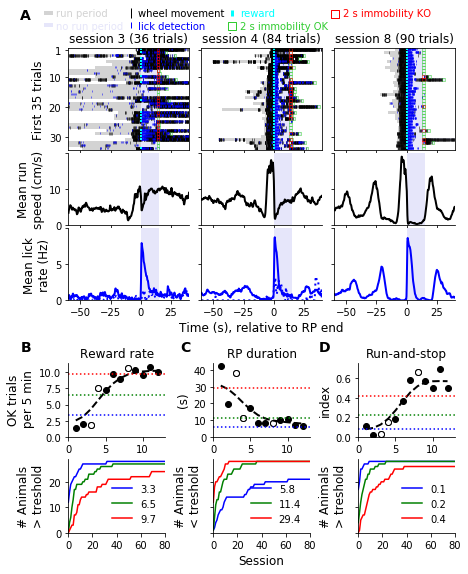

In [8]:
fig=plt.figure(figsize=(cm2inch(17.6),cm2inch(20)))

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=0.93,bottom=0.75,wspace=0.1)

gs2 = gridspec.GridSpec(2, 3)
gs2.update(top=0.745,bottom=0.485,wspace=0.1,hspace=0.05)

gs3 = gridspec.GridSpec(2, 3)
gs3.update(top=0.375,bottom=0.075,wspace=0.5,hspace=0.3)


    


### Example Animal (MOU101)

animal="MOU101"
path=os.path.join(root,animal,"Analysis")
pathPickle=os.path.join(path,"learningStats.p")
with open(pathPickle,"rb") as f:
    results=pickle.load(f)


# sessionsToPlot=["MOU101_2016_01_09_20_47","MOU101_2016_01_14_19_09","MOU101_2016_01_19_15_58"]
# sessionsToPlot=["MOU101_2016_01_11_15_09","MOU101_2016_01_14_19_09","MOU101_2016_01_19_15_58"]
sessionsToPlot=["MOU101_2016_01_13_15_33","MOU101_2016_01_14_19_09","MOU101_2016_01_19_15_58"]
sessionToPlotNumber=[index+1 for index,session in enumerate(results["session"]) if session in sessionsToPlot]
showYLabel=[True,False,False]
showLegendBooleans=[True,False,False]
for index,SessionToPlot in enumerate(sessionsToPlot):
    animal=SessionToPlot[0:6]
    data=Data(root,animal,SessionToPlot,paramCarola,redoPreprocess=False)
    ax=plt.subplot(gs1[index])
    plot_SessionPerfoTryByTrialForFig(data, legend=showLegendBooleans[index],lick=True,yLim=35,showYLabel=showYLabel[index])
    ax.set_title("session %s (%s trials)" %(sessionToPlotNumber[index],data.nTrial)) 

    
    


for index,SessionToPlot in enumerate(sessionsToPlot):
    animal=SessionToPlot[0:6]
    data=Data(root,animal,SessionToPlot,paramCarola,redoPreprocess=False)
    ax=plt.subplot(gs2[index])
    
    # mean run
    plot_MeanPerfo(data,align="trial end",separate="none",minTime=-60,maxTime=40,onlySeparate=False,showYLabel=showYLabel[index])
    
#     if  showYLabel[index]:
#         yticks = ax.yaxis.get_major_ticks()
#         yticks[-1].label1.set_visible(False)

    
    # mean lik
    ax=plt.subplot(gs2[index+3])
    plot_MeanPerfo(data,lick=True,align="trial end",separate="good trial",minTime=-60,maxTime=40,onlySeparate=False,showYLabel=showYLabel[index])



## plot learnng curve of example mice

startSession=0
endSession=12
xaxis=np.arange(startSession+1,endSession+1)
behavioralParamsOfInterest=["Good trials Per 5 Min (trials/5min)","Median Trial Duration (s)","RunAndStopIndex"]
xLabelNames=["OK trials\n per 5 min","(s)","index"]
titleNames=["Reward rate","RP duration","Run-and-stop"]
colorsforHLines=['blue','green','red']



for index,key in enumerate(behavioralParamsOfInterest):
    smoothresult=smooth(results[key][:endSession],2)
    ax=plt.subplot(gs3[index])
    ax.scatter(xaxis,results[key][:endSession],marker='o',color='k')
    ax.scatter(sessionToPlotNumber,[results[key][X-1] for X in sessionToPlotNumber],edgecolors='k',facecolors='w')
    ax.plot(xaxis,smoothresult,'--k',linewidth=2)
    ax.set_xlim([startSession,endSession+1])
    ax.set_ylim(ymin=0)
    ax.locator_params(nbins=5)
    ax.set_ylabel(xLabelNames[index],fontsize=12)
    ax.set_title(titleNames[index],fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

     
    ax.tick_params(axis='both',which='major',labelsize=10)
    
    for insideindex,value in enumerate(allPercentilesValues[key]):
        ax.axhline(value,linestyle=":",color=colorsforHLines[insideindex])
        
        
## plot population performance (bottom panels)

for paramindex,parameter in enumerate(behavioralParamsOfInterest):
    ax=plt.subplot(gs3[paramindex+3])    

    ax.set_xlim([0,80])
    ax.set_ylim([0,29])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.locator_params(axis='x',nbins=5)
    if paramindex==1:
        ax.set_xlabel("Session",fontsize=12)
    
    if paramindex==1:
        ax.set_ylabel("# Animals\n< treshold",fontsize=12)
    else:
        ax.set_ylabel("# Animals\n> treshold",fontsize=12)
    
    if paramindex>0:
        ax.yaxis.set_ticklabels([])
        
    for valueIndex,valueToTest in enumerate(allPercentilesValues[parameter]):  
        #ax.plot(sum(thresholdMatrix[:,:,valueIndex,paramindex],0)/thresholdMatrix.shape[0]*100)
        ax.plot(sum(thresholdMatrix[:,:,valueIndex,paramindex],0),color=colorsforHLines[valueIndex])
        ax.legend(np.round(allPercentilesValues[parameter],1),loc='lower right',fontsize=10,frameon=False)
    
    
    ax.tick_params(axis='both',which='major',labelsize=10)        
        

    

### Labels

figureLabels={"A":[0.05,0.975],"B":[0.05,0.39],"C":[0.37,0.39],"D":[0.65,0.39]}
for label,coordinates in sorted(figureLabels.items()):
    fig.text(coordinates[0],coordinates[1],label,figure=fig,weight='bold',fontsize=14,ha='right' ,va='bottom')

    
fullnameToSaveFigure=os.path.join(pathToSaveFig,'RevisedFig01_BehaviorPerformance.pdf')
plt.savefig(fullnameToSaveFigure,orientation='portrait',dpi=600,format='pdf',papertype='a4')


**Figure 1. Mice became progressively more profficient in the run-and-stop task. A)** 3 illustrative sessions from a given mouse, showing, from left to right, progressive proficiency. Locomotor and lick activity are shown during the first 35 trials (top), along with session-average running speed (middle, all trials) and lick rate (bottom, continous an dashed lines showed lick rates for correct and incorrect trials, respectively) relative to RP end.Due to the variable duration of trials, these session-average data also take in account wheel movements and licks from adjacent trials not shown in the top raster plots (white areas).Immobility OK/KO squares indicate when mice were immobile/runing at the end of no run period.  **B-D)** Session-by-session learning curves (top) for the example mouse shown in A, for three 3 different behavioral metrics. Empty circles correspond to the illutrative sessions shown in A. Colored dashed lines correspond to the 20, 50, 80 percentiles values for each metric, accross all animals. Number of animals passing the 3 performance thresholds versus session number(bottom, same color code and values than in top panels).

## End of the code